In [1]:
!pip install trdg matplotlib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 5.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 5.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4019 sha256=05c32e378bee79343cb2abc36fe561cd140a40fd6f92321af2259a01196f5f8c
  Stored in directory: /root/.cache/pip/wheels/90/57/92/d4259a51f20cf92a473b567a009674e3390852b7fab19be6dc
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=262a62d42488b35875e67d045a89c91792b3df61f690bb1d429077a0d44952d7
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built diffimg wikipedia
  Attempting uninstall: python-bidi
    F

In [2]:
!pip install Pillow==9.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 3.4 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: Pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [1]:
import os
import random
from trdg.generators import GeneratorFromStrings
import matplotlib.pyplot as plt
import pandas as pd  

Missing modules for handwritten text generation.


In [5]:
os.getcwd()

'/workspace'

In [2]:
# Пути к папкам для сохранения данных
train_output_folder = 'generated_data/sah_filtered'
val_output_folder = 'generated_data/val'

os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(val_output_folder, exist_ok=True)

# Пути к файлам с текстом и шрифтами
fonts_list_file = 'text/okfonts_test.txt'
fonts_dir = '.'
text_file = 'text/sah.wordlist'

In [3]:
font_paths = []

with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]

for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [4]:
with open(text_file, 'r', encoding='utf-8') as f:
    lines = [line.strip() for line in f if line.strip()]

print(f"Общее количество строк для генерации: {len(lines)}")

random.shuffle(lines)

Общее количество строк для генерации: 40117


In [5]:
# Разделение на тренировочный и валидационный наборы
validation_split = 0.2  # 20% данных для валидации
split_index = int(len(lines) * (1 - validation_split))

train_lines = lines[:split_index]
val_lines = lines[split_index:]

print(f"Количество тренировочных строк: {len(train_lines)}")
print(f"Количество валидационных строк: {len(val_lines)}")

Количество тренировочных строк: 32093
Количество валидационных строк: 8024


In [6]:
# Настройка генератора TRDG
generator_settings = {
    'fonts': font_paths,
    'size': 32,                  # Размер шрифта (можете настроить под свои нужды)
    'background_type': 0,        # Тип фона: 0 - однородный, 1 - шум, 2 - градиент
    'image_mode': 'RGB',
    'text_color': 'black',
    'skewing_angle': 0,
    'random_skew': False,
    'blur': 0,
    'random_blur': False,
    'is_handwritten': False,
    'alignment': 1,
    'width': 600,
    'fit': True,
    'space_width': 1.0,
    'character_spacing': 0,
    'stroke_width': 0,
    'stroke_fill': '#ffffff'
}

In [7]:
# Функция для генерации данных и сохранения в CSV
def generate_and_save(generator, lines, output_folder, csv_filename):
    labels = []
    for idx, (img, lbl) in enumerate(generator):
        image_filename = f"{idx}.jpg"
        image_path = os.path.join(output_folder, image_filename)
        img.save(image_path)
        labels.append((image_filename, lbl))
        
        if (idx + 1) % 1000 == 0:
            print(f"Сгенерировано {idx + 1} изображений в {output_folder}...")
    
    print(f"Генерация в {output_folder} завершена. Всего сгенерировано {len(labels)} изображений.")
    
    # Сохранение меток в labels.csv с использованием pandas
    df_labels = pd.DataFrame(labels, columns=['filename', 'words'])
    labels_csv_path = os.path.join(output_folder, csv_filename)
    df_labels.to_csv(labels_csv_path, index=False, encoding='utf-8')
    
    print(f"Файл меток сохранен: {labels_csv_path}")

In [11]:
# Генерация тренировочных данных
print("Генерация тренировочных изображений...")
train_generator = GeneratorFromStrings(
    strings=train_lines,
    count=len(train_lines),
    **generator_settings
)
generate_and_save(train_generator, train_lines, train_output_folder, 'labels.csv')

Генерация тренировочных изображений...
Сгенерировано 1000 изображений в generated_data/sah_filtered...
Сгенерировано 2000 изображений в generated_data/sah_filtered...
Сгенерировано 3000 изображений в generated_data/sah_filtered...
Сгенерировано 4000 изображений в generated_data/sah_filtered...
Сгенерировано 5000 изображений в generated_data/sah_filtered...
Сгенерировано 6000 изображений в generated_data/sah_filtered...
Сгенерировано 7000 изображений в generated_data/sah_filtered...
Сгенерировано 8000 изображений в generated_data/sah_filtered...
Сгенерировано 9000 изображений в generated_data/sah_filtered...
Сгенерировано 10000 изображений в generated_data/sah_filtered...
Сгенерировано 11000 изображений в generated_data/sah_filtered...
Сгенерировано 12000 изображений в generated_data/sah_filtered...
Сгенерировано 13000 изображений в generated_data/sah_filtered...
Сгенерировано 14000 изображений в generated_data/sah_filtered...
Сгенерировано 15000 изображений в generated_data/sah_filtere

In [8]:
# Генерация валидационных данных
print("Генерация валидационных изображений...")
val_generator = GeneratorFromStrings(
    strings=val_lines,
    count=len(val_lines),
    **generator_settings
)
generate_and_save(val_generator, val_lines, val_output_folder, 'labels.csv')

Генерация валидационных изображений...
Сгенерировано 1000 изображений в generated_data/val...
Сгенерировано 2000 изображений в generated_data/val...
Сгенерировано 3000 изображений в generated_data/val...
Сгенерировано 4000 изображений в generated_data/val...
Сгенерировано 5000 изображений в generated_data/val...
Сгенерировано 6000 изображений в generated_data/val...
Сгенерировано 7000 изображений в generated_data/val...
Сгенерировано 8000 изображений в generated_data/val...
Генерация в generated_data/val завершена. Всего сгенерировано 8024 изображений.
Файл меток сохранен: generated_data/val/labels.csv


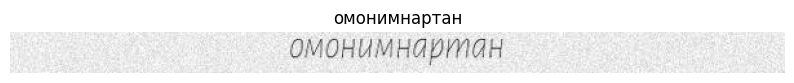

In [10]:
# Отображение примера сгенерированного изображения
sample_image_path = os.path.join(val_output_folder, '0.jpg')
if os.path.exists(sample_image_path):
    img = plt.imread(sample_image_path)
    plt.figure(figsize=(10, 4))
    plt.imshow(img)
    plt.axis('off')
    # Загрузка меток для отображения
    df_train_labels = pd.read_csv(os.path.join(val_output_folder, 'labels.csv'))
    plt.title(df_train_labels.iloc[0]['words'])
    plt.show()
else:
    print(f"Сгенерированное изображение {sample_image_path} не найдено.")

In [2]:
# Пути к папкам для сохранения данных
train_output_folder = 'generated_data/sah_filtered'
val_output_folder = 'generated_data/val'

os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(val_output_folder, exist_ok=True)

# Пути к файлам с текстом и шрифтами
fonts_list_file = 'text/okfonts_test.txt'
fonts_dir = '.'
text_file = 'text/sah_texts.txt'

In [3]:
font_paths = []

with open(fonts_list_file, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]

for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(fonts_dir, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                font_paths.append(font_path)

print(f"Количество найденных файлов шрифтов: {len(font_paths)}")

Количество найденных файлов шрифтов: 75


In [4]:
with open(text_file, 'r', encoding='utf-8') as f:
    sentences = [line.strip() for line in f if line.strip()]

print(f"Общее количество строк для генерации: {len(sentences)}")

Общее количество строк для генерации: 61926


In [13]:
import textwrap

# Разделяет длинные предложения на несколько строк, каждая из которых не превышает max_length символов.
# def split_long_sentences(sentences, max_length=70):
#     split_sentences = []
#     for sentence in sentences:
#         wrapped = textwrap.wrap(sentence, width=max_length, break_long_words=False, replace_whitespace=False)
#         if wrapped:
#             split_sentences.extend(wrapped)
#         else:
#             split_sentences.append('')  # Или пропустить
#     return split_sentences

def split_long_sentences(sentences, max_length=70):
    split_sentences = []
    for sentence in sentences:
        if sentence.strip():  # Проверка на непустую строку
            wrapped = textwrap.wrap(sentence, width=max_length, break_long_words=False, replace_whitespace=False)
            split_sentences.extend(wrapped)
    return split_sentences

In [22]:
import re

def clean_text(text):
    text = re.sub(r'[—‒–‐]', '-', text)

    text = re.sub(r'[\'\"\‟\„\‘\’\“\”]', '"', text)

    text = text.lower()

    text = re.sub(r'[^0-9а-яёһөҕүҥ.,\-:;?!]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Разделяет список `lst` на `n` примерно равных частей.
def split_list(lst, n):
    k, m = divmod(len(lst), n)
    return [lst[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

cleaned_sentences = [clean_text(sentence) for sentence in sentences]
lines = cleaned_sentences
lines = split_long_sentences(lines, max_length=70)

split_parts = split_list(lines, 4)
for idx, part in enumerate(split_parts, 1):
    print(f"Часть {idx}: {len(part)} строк")
    
print(f"Общее количество строк для генерации: {len(lines)}")

lines = split_parts[0]

print(f"Общее количество строк для генерации: {len(lines)}")

Часть 1: 75656 строк
Часть 2: 75656 строк
Часть 3: 75655 строк
Часть 4: 75655 строк
Общее количество строк для генерации: 302622
Общее количество строк для генерации: 75656


In [23]:
# Разделение на тренировочный и валидационный наборы
validation_split = 0.2  # 20% данных для валидации
split_index = int(len(lines) * (1 - validation_split))

train_lines = lines[:split_index]
val_lines = lines[split_index:]

print(f"Количество тренировочных строк: {len(train_lines)}")
print(f"Количество валидационных строк: {len(val_lines)}")

Количество тренировочных строк: 60524
Количество валидационных строк: 15132


In [24]:
# Настройка генератора TRDG
generator_settings = {
    'fonts': font_paths,
    'size': 32,                  # Размер шрифта (можете настроить под свои нужды)
    'background_type': 0,        # Тип фона: 0 - однородный, 1 - шум, 2 - градиент
    'image_mode': 'RGB',
    'text_color': 'black',
    'skewing_angle': 0,
    'random_skew': False,
    'blur': 0,
    'random_blur': False,
    'is_handwritten': False,
    'alignment': 1,
    'width': 1600,
    'fit': True,
    'space_width': 1.0,
    'character_spacing': 0,
    'stroke_width': 0,
    'stroke_fill': '#ffffff'
}

In [25]:
# Функция для генерации данных и сохранения в CSV
def generate_and_save(generator, lines, output_folder, csv_filename):
    labels = []
    for idx, (img, lbl) in enumerate(generator):
        image_filename = f"{idx}.jpg"
        image_path = os.path.join(output_folder, image_filename)
        img.save(image_path)
        labels.append((image_filename, lbl))
        
        if (idx + 1) % 1000 == 0:
            print(f"Сгенерировано {idx + 1} изображений в {output_folder}...")
    
    print(f"Генерация в {output_folder} завершена. Всего сгенерировано {len(labels)} изображений.")
    
    # Сохранение меток в labels.csv с использованием pandas
    df_labels = pd.DataFrame(labels, columns=['filename', 'words'])
    labels_csv_path = os.path.join(output_folder, csv_filename)
    df_labels.to_csv(labels_csv_path, index=False, encoding='utf-8')
    
    print(f"Файл меток сохранен: {labels_csv_path}")

In [27]:
# Генерация тренировочных данных
print("Генерация тренировочных изображений...")
train_generator = GeneratorFromStrings(
    strings=train_lines,
    count=len(train_lines),
    **generator_settings
)
generate_and_save(train_generator, train_lines, train_output_folder, 'labels.csv')

Генерация тренировочных изображений...
Сгенерировано 1000 изображений в generated_data/sah_filtered...
Сгенерировано 2000 изображений в generated_data/sah_filtered...
Сгенерировано 3000 изображений в generated_data/sah_filtered...
Сгенерировано 4000 изображений в generated_data/sah_filtered...
Сгенерировано 5000 изображений в generated_data/sah_filtered...
Сгенерировано 6000 изображений в generated_data/sah_filtered...
Сгенерировано 7000 изображений в generated_data/sah_filtered...
Сгенерировано 8000 изображений в generated_data/sah_filtered...
Сгенерировано 9000 изображений в generated_data/sah_filtered...
Сгенерировано 10000 изображений в generated_data/sah_filtered...
Сгенерировано 11000 изображений в generated_data/sah_filtered...
Сгенерировано 12000 изображений в generated_data/sah_filtered...
Сгенерировано 13000 изображений в generated_data/sah_filtered...
Сгенерировано 14000 изображений в generated_data/sah_filtered...
Сгенерировано 15000 изображений в generated_data/sah_filtere

In [26]:
# Генерация валидационных данных
print("Генерация валидационных изображений...")
val_generator = GeneratorFromStrings(
    strings=val_lines,
    count=len(val_lines),
    **generator_settings
)
generate_and_save(val_generator, val_lines, val_output_folder, 'labels.csv')

Генерация валидационных изображений...
Сгенерировано 1000 изображений в generated_data/val...
Сгенерировано 2000 изображений в generated_data/val...
Сгенерировано 3000 изображений в generated_data/val...
Сгенерировано 4000 изображений в generated_data/val...
Сгенерировано 5000 изображений в generated_data/val...
Сгенерировано 6000 изображений в generated_data/val...
Сгенерировано 7000 изображений в generated_data/val...
Сгенерировано 8000 изображений в generated_data/val...
Сгенерировано 9000 изображений в generated_data/val...
Сгенерировано 10000 изображений в generated_data/val...
Сгенерировано 11000 изображений в generated_data/val...
Сгенерировано 12000 изображений в generated_data/val...
Сгенерировано 13000 изображений в generated_data/val...
Сгенерировано 14000 изображений в generated_data/val...
Сгенерировано 15000 изображений в generated_data/val...
Генерация в generated_data/val завершена. Всего сгенерировано 15132 изображений.
Файл меток сохранен: generated_data/val/labels.cs